# Vanilla RNN - Tensorflow API - Dynamic - Predicting binary sequences

In this notebook we will implement a "cleaner" (without explanations, examples, images...) of the last model, the one using the dynamic API.

In [1]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

## Hyperparameters

In [2]:
NUM_OBSERVATIONS = 10000

NUM_STEPS = 10 #Number of truncated backprop steps
BATCH_SIZE = 3
NUM_CLASSES = 2 #Binary problem

STATE_SIZE = 16

LEARNING_RATE = 0.1

DISPLAY_FREQ = NUM_OBSERVATIONS//NUM_STEPS//BATCH_SIZE//10

In [3]:
print('With current configuration %d batches per epoch' % (NUM_OBSERVATIONS//NUM_STEPS//BATCH_SIZE))

With current configuration 333 batches per epoch


## Functions

In [4]:
def gen_data(size=NUM_OBSERVATIONS):
    X = np.array(np.random.choice(2,size=(size,))) #Random binary array of size 'size'
    Y = [] #Targets
    
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1: #First dependency at t-3
            threshold += 0.5 
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
            
    return X,np.array(Y)

def gen_batch(raw_data,batch_size,num_steps):
    raw_x,raw_y = raw_data
    data_length = len(raw_x)
    
    #Partition data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length//batch_size
    
    data_x = np.zeros(shape=(batch_size,batch_partition_length),dtype=np.int32)
    data_y = np.zeros(shape=(batch_size,batch_partition_length),dtype=np.int32)
    
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length*i : batch_partition_length*(i+1)]
        data_y[i] = raw_y[batch_partition_length*i : batch_partition_length*(i+1)]
        
    #Further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps
    
    for i in range(epoch_size):
        x = data_x[:,i * num_steps:(i+1) * num_steps]
        y = data_y[:,i * num_steps:(i+1) * num_steps]
        yield(x,y)
        
def gen_epochs(num_epochs,batch_size,num_steps):
    for i in range(num_epochs):
        yield gen_batch(gen_data(),batch_size,num_steps)

## Model

In [5]:
#Placeholders

x = tf.placeholder(shape=[BATCH_SIZE,NUM_STEPS],dtype=tf.int32,name='input_placeholder')
y = tf.placeholder(shape=[BATCH_SIZE,NUM_STEPS],dtype=tf.int32,name='labels_placeholder')
init_state = tf.zeros([BATCH_SIZE,STATE_SIZE],dtype=tf.float32)

#RNN inputs
rnn_inputs = tf.one_hot(x,NUM_CLASSES)

#RNN cell
cell = tf.contrib.rnn.BasicRNNCell(STATE_SIZE)

#Add RNN cells to graph
rnn_outputs, final_state = tf.nn.dynamic_rnn(cell=cell,inputs=rnn_inputs,initial_state=init_state)

#Predictions
with tf.variable_scope('softmax'):
    W = tf.get_variable('W',[STATE_SIZE,NUM_CLASSES])
    b = tf.get_variable('b',[NUM_CLASSES],initializer=tf.constant_initializer(0.0))
    
logits = tf.reshape(tf.matmul(tf.reshape(rnn_outputs,shape=[-1,STATE_SIZE]),W) + b,shape=[BATCH_SIZE,NUM_STEPS,NUM_CLASSES])
predictions = tf.nn.softmax(logits)

#Loss
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
total_loss = tf.reduce_mean(losses)

#Optimizer
train_step = tf.train.AdagradOptimizer(LEARNING_RATE).minimize(total_loss)

## Train

In [6]:
def train_network(num_epochs):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        
        for idx,epoch in enumerate(gen_epochs(num_epochs,BATCH_SIZE,NUM_STEPS)):
            training_loss = 0
            training_state = np.random.normal(size=(BATCH_SIZE,STATE_SIZE)) #Random initiate state
        
            print('Epoch %d'%idx)
            
            for step,(X,Y) in enumerate(epoch):
                
                feed_dict = {x:X,y:Y,init_state:training_state}
                tr_losses,training_loss_,training_state,_ = sess.run([losses,total_loss,final_state,train_step],feed_dict)
                training_loss += training_loss_
                
                if(step % 100 == 0 and step > 0):
                    print('Average loss at step %d for last 250 steps: %.3f'%(step,training_loss/100))
                    training_losses.append(training_loss/100)
                    training_loss = 0
                
    return training_losses

In [7]:
training_losses = train_network(num_epochs=10)

Epoch 0
Average loss at step 100 for last 250 steps: 0.562
Average loss at step 200 for last 250 steps: 0.499
Average loss at step 300 for last 250 steps: 0.481
Epoch 1
Average loss at step 100 for last 250 steps: 0.501
Average loss at step 200 for last 250 steps: 0.502
Average loss at step 300 for last 250 steps: 0.477
Epoch 2
Average loss at step 100 for last 250 steps: 0.483
Average loss at step 200 for last 250 steps: 0.481
Average loss at step 300 for last 250 steps: 0.482
Epoch 3
Average loss at step 100 for last 250 steps: 0.479
Average loss at step 200 for last 250 steps: 0.477
Average loss at step 300 for last 250 steps: 0.481
Epoch 4
Average loss at step 100 for last 250 steps: 0.502
Average loss at step 200 for last 250 steps: 0.473
Average loss at step 300 for last 250 steps: 0.483
Epoch 5
Average loss at step 100 for last 250 steps: 0.473
Average loss at step 200 for last 250 steps: 0.480
Average loss at step 300 for last 250 steps: 0.467
Epoch 6
Average loss at step 100 f

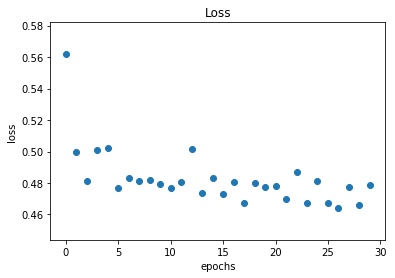

In [8]:
plt.title('Loss')
plt.scatter(x=np.arange(0,len(training_losses)),y=training_losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show();